# Install

In [ ]:
!pip install transformers

In [ ]:
import torch.cuda as cuda
import pandas as pd
import csv
import random
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
import numpy as np
import gc
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pre-processing and analysis

In [ ]:
file_path1 = 'Movies_and_TV_5.json'
file_path2 = 'Home_and_Kitchen_5.json'
file_path3 = 'Office_Products_5.json'
file_path4 = 'Pet_Supplies_5.json'

df1 = pd.read_json(file_path1,nrows=50000,lines=True)
df2 = pd.read_json(file_path2,nrows=50000,lines=True)
df3 = pd.read_json(file_path3,nrows=50000,lines=True)
df4 = pd.read_json(file_path4,nrows=50000,lines=True)

view_df = pd.concat([df, df2], ignore_index=True)
view_df = pd.concat([view_df, df3], ignore_index=True)
view_df = pd.concat([view_df, df4], ignore_index=True)

In [ ]:
view_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349945 entries, 0 to 349944
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   reviewerID        349945 non-null  object 
 1   asin              349945 non-null  object 
 2   reviewText        349912 non-null  object 
 3   category          199945 non-null  float64
 4   overall           349945 non-null  int64  
 5   overall_category  199945 non-null  object 
 6   verified          150000 non-null  object 
 7   reviewTime        150000 non-null  object 
 8   reviewerName      149981 non-null  object 
 9   summary           149982 non-null  object 
 10  unixReviewTime    150000 non-null  float64
 11  vote              17375 non-null   object 
 12  style             115498 non-null  object 
 13  image             1702 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory usage: 37.4+ MB


In [ ]:
view_df.describe()

,category,overall,unixReviewTime
count,199945.000000,349945.000000,1.500000e+05
mean,1.500058,3.942045,1.422324e+09
std,1.118030,1.099168,8.105556e+07
min,0.000000,0.000000,9.396000e+08
25%,1.000000,4.000000,1.396570e+09
50%,2.000000,4.000000,1.436486e+09
75%,3.000000,5.000000,1.473638e+09
max,3.000000,5.000000,1.526342e+09


In [ ]:
text_lengths = df['reviewText'].str.len()

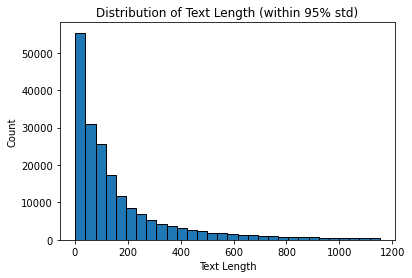

In [ ]:
mean_length = np.mean(text_lengths)
std_length = np.std(text_lengths)


lower_bound = mean_length - 2 * std_length
upper_bound = mean_length + 2 * std_length


filtered_lengths = text_lengths[(text_lengths >= lower_bound) & (text_lengths <= upper_bound)]


plt.hist(filtered_lengths, bins=30, edgecolor='k')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Distribution of Text Length (within 95% std)')
plt.show()

In [ ]:
columns_to_select = ['reviewerID', 'asin', 'reviewText', 'overall']
df1_selected = df1[columns_to_select]
df2_selected = df2[columns_to_select]
df3_selected = df3[columns_to_select]
df4_selected = df4[columns_to_select]

merged_df = pd.concat([df1_selected, df2_selected], ignore_index=True)
merged_df = pd.concat([merged_df, df3_selected], ignore_index=True)
merged_df = pd.concat([merged_df, df4_selected], ignore_index=True)

In [ ]:
merged_df = merged_df.dropna()

In [ ]:
merged_df['overall'] = merged_df['overall'].astype(int) -1

In [ ]:
def preprocess_text(text):

    text = text.lower()


    text = re.sub('<.*?>', '', text)


    text = re.sub(r'[^\w\s]', '', text)


    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [ ]:
merged_df['reviewText'] = merged_df['reviewText'].apply(preprocess_text)

In [ ]:
merged_df.to_csv('products_database.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

### Reading dataset

In [ ]:
project = pd.read_csv('products_database.csv', on_bad_lines='skip')

In [ ]:
project = project.dropna()

In [ ]:
dataset = list(project[['reviewText','overall']].to_records(index=False))
del project

In [ ]:
dataset, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Sentiment Classification

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

max_sequence_length = 256


In [ ]:
input_ids = []
attention_masks = []
labels = []
i = 0

for text, label in dataset:
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_sequence_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_text['input_ids'])
    attention_masks.append(encoded_text['attention_mask'])
    labels.append(label)

In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
train_dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)

In [ ]:
file_path = 'train_dataset_inputs_mid.pth'

torch.save(train_dataset, file_path)

In [ ]:
from tqdm import tqdm

In [ ]:
def train_model(learning_rate, epochs, batch_size):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  model.train()

  for epoch in range(epochs):
      train_loader = tqdm(train_loader, desc='Training', leave=False)
      total_correct = 0
      total_samples = 0
      for batch in train_loader:
          input_ids_batch, attention_masks_batch, labels_batch = batch
          input_ids_batch = input_ids_batch.to(device)
          attention_masks_batch = attention_masks_batch.to(device)
          labels_batch = labels_batch.to(device)

          optimizer.zero_grad()

          outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels_batch)
          loss = outputs.loss
          logits = outputs.logits

          _, predicted = torch.max(logits, dim=1)
          correct = (predicted == labels_batch).sum().item()
          total_correct += correct
          total_samples += labels_batch.size(0)

          accuracy = total_correct / total_samples

          loss.backward()
          optimizer.step()
          train_loader.set_postfix({'Epoch': epoch, 'Accuracy': accuracy, 'Loss': loss.item()})
          train_loader.update()

  return model

In [ ]:
model = train_model(5e-5,5,16)

In [ ]:
torch.save(model.state_dict(), 'fine_tuned_model.pth')

In [ ]:
def normalize_value(input_value):
    normalized_value = (input_value / 4) * 100
    return normalized_value

def mean_difference(true_labels, predicted_labels):
    differences = torch.abs(predicted_labels - true_labels).float()
    score = (4-torch.mean(differences))
    score = normalize_value(score)
    return score

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model.load_state_dict(torch.load('fine_tuned_model.pth'))
device = torch.device('cuda:0')
model = model.to(device)

## Test

In [ ]:
def prepare_test(test_data):
  test_dataset = test_data
  test_input_ids = []
  test_attention_masks = []
  test_labels = []
  # Convert your text data into input IDs and attention masks
  for text, label in test_dataset:
      encoded_text = tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=max_sequence_length,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt'
      )
      test_input_ids.append(encoded_text['input_ids'])
      test_attention_masks.append(encoded_text['attention_mask'])
      test_labels.append(label)

  test_input_ids = torch.cat(test_input_ids, dim=0)
  test_attention_masks = torch.cat(test_attention_masks, dim=0)
  test_labels = torch.tensor(test_labels)
  test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_labels)
  return test_dataset

In [ ]:
test_dataset = prepare_test(test_data)

In [ ]:
file_path = 'test_dataset_inputs.pth'

torch.save(test_dataset, file_path)

In [ ]:
def run_test(test_dataset,model):
  correct = 0
  total = 0
  scoring_total = 0
  iterations = 0
  results = []
  dataset_labels = []
  test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
      for batch in test_loader:
          iterations = iterations+1
          input_ids_batch, attention_masks_batch, labels_batch = batch
          input_ids_batch = input_ids_batch.to(device)
          attention_masks_batch = attention_masks_batch.to(device)
          labels_batch = labels_batch.to(device)

          outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
          logits = outputs.logits

          _, predicted = torch.max(logits, dim=1)
          total += labels_batch.size(0)

          correct += (predicted == labels_batch).sum().item()
          scoring_val = mean_difference(labels_batch, predicted)
          scoring_total += scoring_val
          results.append(predicted)
          dataset_labels.append(labels_batch)

  accuracy = 100 * correct / total
  scoring_total = scoring_total.item()/iterations

  return accuracy,scoring_total,results,dataset_labels

In [ ]:
test_dataset = torch.load('test_dataset_inputs.pth')

In [ ]:
accuracy,scoring,test_results,dataset_labels = run_test(test_dataset,model)

In [ ]:
print(accuracy,scoring)

72.68135330449351 90.197451171875


### Metrics

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
test_array = np.concatenate([np.array([t.cpu() for t in sublist]) for sublist in test_results])
predicted_array = np.concatenate([np.array([t.cpu() for t in sublist]) for sublist in dataset_labels])


test_flat = test_array.flatten()
predicted_flat = predicted_array.flatten()

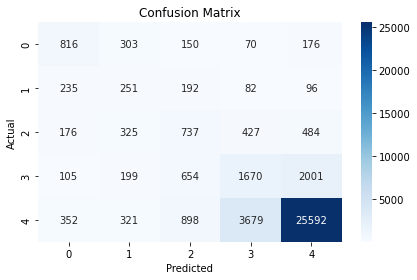

In [ ]:
confusion_mat = confusion_matrix(test_flat, predicted_flat)

# Create a heatmap using seaborn
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and adjust plot settings
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

# Display the plot
plt.show()


# Analysis

In [ ]:
def read_json(file, skiprows=None):
    with open(file) as f:
        if skiprows:
            f.readlines(skiprows)
        df = pd.read_json(f, lines=True)
    return df

In [ ]:
file_path1 = 'Movies_and_TV_5.json'
file_path2 = 'Home_and_Kitchen_5.json'
file_path3 = 'Office_Products_5.json'
file_path4 = 'Pet_Supplies_5.json'

df1_2 = pd.read_json(file_path1, nrows=100000, lines=True)[50001:100000]
df1_2['category'] = 0
df2_2 = pd.read_json(file_path2, nrows=100000, lines=True)[50001:100000]
df2_2['category'] = 1
df3_2 = pd.read_json(file_path3, nrows=100000, lines=True)[50001:100000]
df3_2['category'] = 2
df4_2 = pd.read_json(file_path4, nrows=100000, lines=True)[50001:100000]
df4_2['category'] = 3

In [ ]:
columns_to_select = ['reviewerID', 'asin', 'reviewText','category']
df1_2selected = df1_2[columns_to_select]
df2_2selected = df2_2[columns_to_select]
df3_2selected = df3_2[columns_to_select]
df4_2selected = df4_2[columns_to_select]

merged_df2 = pd.concat([df1_2selected, df2_2selected], ignore_index=True)
merged_df2 = pd.concat([merged_df2, df3_2selected], ignore_index=True)
merged_df2 = pd.concat([merged_df2, df4_2selected], ignore_index=True)

In [ ]:
merged_df2 = merged_df2.dropna()

In [ ]:
merged_df2['reviewText'] = merged_df2['reviewText'].apply(preprocess_text)

In [ ]:
merged_df2.to_csv('products_database_to_review.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [ ]:
project = pd.read_csv('products_database_to_review.csv', on_bad_lines='skip')

In [ ]:
project = project.dropna()
dataset = list(project[['reviewText']].to_records(index=False))
del project

# Execution

In [ ]:
input_ids = []
attention_masks = []
for text in dataset:
    encoded_text = tokenizer.encode_plus(
        str(text),
        add_special_tokens=True,
        max_length=max_sequence_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_text['input_ids'])
    attention_masks.append(encoded_text['attention_mask'])

In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
run_dataset = torch.utils.data.TensorDataset(input_ids, attention_masks)

In [ ]:
def predict(test_dataset,model):
  correct = 0
  total = 0
  scoring_total = 0
  iterations = 0
  results = []
  test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
      for batch in test_loader:
          iterations = iterations+1
          input_ids_batch, attention_masks_batch = batch
          input_ids_batch = input_ids_batch.to(device)
          attention_masks_batch = attention_masks_batch.to(device)

          outputs = model(input_ids_batch, attention_mask=attention_masks_batch)
          logits = outputs.logits

          _, predicted = torch.max(logits, dim=1)

          results.append(predicted)

  return results

In [ ]:
results = predict(run_dataset,model)

In [ ]:
results_list = [tensor.cpu().numpy().tolist() for tensor in results]

In [ ]:
import itertools

In [ ]:
flattened_list = list(itertools.chain(*results_list))

In [ ]:
project = pd.read_csv('products_database_to_review.csv', on_bad_lines='skip')
project['overall'] = flattened_list

In [ ]:
project.to_csv('products_database_reviewed.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

# LDA & TextRank

In [ ]:
!pip install pyLDAvis
!pip install gensim
!pip install spacy
!python3 -m spacy download en_core_web_sm

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim as gensimvis
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import spacy.cli
spacy.cli.download("en_core_web_md")
import en_core_web_md
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
df = pd.read_csv('products_database_reviewed.csv', on_bad_lines='skip')

In [ ]:
df['overall_category'] = df['overall'].replace({0: 'negative', 1: 'negative', 2: 'neutral', 3: 'good', 4: 'good'})

In [ ]:
df['reviewText'] = df['reviewText'].apply(lambda x: str(x).replace("'", ""))

In [ ]:
negative_df = df[df['overall_category'] == 'negative']
neutral_df = df[df['overall_category'] == 'neutral']
good_df = df[df['overall_category'] == 'good']

In [ ]:
LDA = gensim.models.ldamodel.LdaModel

In [ ]:
def tokenize(dataset):
    nlp = en_core_web_md.load(disable=['parser', 'ner'])

    def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']):
            output = []
            for sent in texts:
                doc = nlp(sent)
                output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
            return output

    text_list=dataset['reviewText'].tolist()
    tokenized_reviews = lemmatization(text_list)
    return tokenized_reviews

In [ ]:
def runLDA(dataset):
    tokenized_reviews = tokenize(dataset)
    dictionary = corpora.Dictionary(tokenized_reviews)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,
                num_topics=15, random_state=100,
                chunksize=1000, passes=50,iterations=100)
    # print lda topics with respect to each word of document
    return lda_model,dictionary,doc_term_matrix,tokenized_reviews

In [ ]:
def get_indicators(lda_model,total_docs,dictionary,tokenized_reviews,doc_term_matrix):
    perplexity = lda_model.log_perplexity(doc_term_matrix,total_docs=total_docs)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=tokenized_reviews, dictionary=dictionary ,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    return perplexity,coherence_lda

In [ ]:
def get_topics(topics):
    topic_terms = []
    for topic in topics:
        topic_number, topic_terms_str = topic
        terms = topic_terms_str.split('"')[1::2]
        topic_terms.append(terms)
    return topic_terms

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
lda_model_negative,dictionary_negative,doc_term_matrix_negative,tokenized_reviews_negative = runLDA(negative_df)

In [ ]:
perplexity_negative,coherence_lda_negative = get_indicators(lda_model_negative,len(negative_df),dictionary_negative,tokenized_reviews_negative,doc_term_matrix_negative)
print('Perplexity: ',perplexity_negative)
print('Coherence: ', coherence_lda_negative)

Perplexity:  -10.542183754425968
Coherence:  0.44280501739690803


In [ ]:
negative_topics = get_topics(lda_model_negative.print_topics())

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_negative, doc_term_matrix_negative, dictionary_negative)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.341716 -0.002294       1        1  27.566000
1     -0.242402 -0.062229       2        1  20.461395
10    -0.287759 -0.053858       3        1  11.651500
13    -0.181361  0.192493       4        1  10.789982
5     -0.122433 -0.155086       5        1   9.520712
7      0.002812  0.290461       6        1   3.521431
9      0.012085 -0.113246       7        1   2.882036
12     0.077437 -0.055846       8        1   2.673575
0      0.106862  0.055140       9        1   2.186031
11     0.154935  0.082794      10        1   1.840023
6      0.148305 -0.030302      11        1   1.837898
2      0.160223 -0.045839      12        1   1.642776
4      0.168536 -0.041161      13        1   1.255520
8      0.172323 -0.032154      14        1   1.112660
3      0.172151 -0.028874      15        1   1.058461, topic_info=           Term         Freq        Total Category  logprob  loglift
337         dog  1526.000000  1526.000000  Default  30.0000  30.0000
14        movie  3541.000000  3541.000000  Default  29.0000  29.0000
252       money  1205.000000  1205.000000  Default  28.0000  28.0000
2786    plastic  1049.000000  1049.000000  Default  27.0000  27.0000
3013        cat  1039.000000  1039.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
77         slow    88.476715   152.426522  Topic15  -3.4841   4.0044
869     episode    33.709580    79.931068  Topic15  -4.4491   3.6850
110   difficult    69.417985   378.273912  Topic15  -3.7267   2.8529
920        open    24.044731   365.852560  Topic15  -4.7869   1.8260
3120    morning    14.637207   135.742848  Topic15  -5.2833   2.3212

[675 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5345      7  0.965011  absolute
1217      8  0.969562    absurd
1196      1  0.207959  accurate
1196     10  0.782323  accurate
0         2  0.995320    acting
...     ...       ...       ...
1027      2  0.114849      year
2020     10  0.979070    yellow
774       2  0.954877     young
774       5  0.039787     young
4196     13  0.945529      zone

[922 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 11, 14, 6, 8, 10, 13, 1, 12, 7, 3, 5, 9, 4])

In [ ]:
lda_model_neutral,dictionary_neutral,doc_term_matrix_neutral,tokenized_reviews_neutral = runLDA(neutral_df)

In [ ]:
perplexity_neutral,coherence_lda_neutral = get_indicators(lda_model_neutral,len(neutral_df),dictionary_neutral,tokenized_reviews_neutral,doc_term_matrix_neutral)
print('Perplexity: ',perplexity_neutral)
print('Coherence: ', coherence_lda_neutral)

Perplexity:  -10.364982031952978
Coherence:  0.4654694597747022


In [ ]:
neutral_topics = get_topics(lda_model_neutral.print_topics())

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_neutral, doc_term_matrix_neutral, dictionary_neutral)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.336338  0.090568       1        1  26.707532
14     0.285562 -0.184275       2        1  23.672418
10     0.335544  0.097502       3        1  19.180653
3      0.066442 -0.302743       4        1   8.805030
2     -0.063833 -0.087834       5        1   3.945409
13     0.164903  0.227144       6        1   3.893863
5      0.003122 -0.072543       7        1   3.741508
11    -0.101117  0.003038       8        1   2.456723
12    -0.118423  0.035275       9        1   1.780742
7     -0.119440  0.043283      10        1   1.404034
4     -0.149759  0.029689      11        1   1.136608
0     -0.148769  0.040065      12        1   1.104138
6     -0.162124  0.029785      13        1   0.812718
1     -0.162432  0.024127      14        1   0.780222
9     -0.166014  0.026918      15        1   0.578401, topic_info=             Term         Freq        Total Category  logprob  loglift
75           film  3982.000000  3982.000000  Default  30.0000  30.0000
9           movie  4535.000000  4535.000000  Default  29.0000  29.0000
4398          dog  1364.000000  1364.000000  Default  28.0000  28.0000
1179      product  1355.000000  1355.000000  Default  27.0000  27.0000
124         small  1353.000000  1353.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4819       suitor     3.167459     4.291573  Topic15  -6.2799   4.8489
4737  nightmarish     2.866714     3.990830  Topic15  -6.3796   4.8218
498        corner    28.497754    91.498183  Topic15  -4.0830   3.9862
2453      helping     4.175894     8.137961  Topic15  -6.0035   4.4854
4470     triangle     3.339830     6.265165  Topic15  -6.2269   4.5236

[712 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6580      6  0.806760    25th
1757      5  0.957554      60
6581      3  0.052432      80
6581      8  0.908823      80
6581     11  0.017477      80
...     ...       ...     ...
204       4  0.059498    year
1019     11  0.989654  yellow
138       2  0.892827   young
138       5  0.079870   young
138       8  0.025672   young

[951 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 11, 4, 3, 14, 6, 12, 13, 8, 5, 1, 7, 2, 10])

In [ ]:
lda_model_positive,dictionary_positive,doc_term_matrix_positive,tokenized_reviews_positive = runLDA(good_df)
perplexity_positive,coherence_lda_positive = get_indicators(lda_model_positive,len(neutral_df),dictionary_positive,tokenized_reviews_positive,doc_term_matrix_positive)
print('Perplexity: ',perplexity_positive)
print('Coherence: ', coherence_lda_positive)

In [ ]:
positive_topics = get_topics(lda_model_positive.print_topics())

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_positive, doc_term_matrix_positive, dictionary_positive)
LDAvis_prepared

In [ ]:
def get_difference(extracted_positive,extracted_neutral,extracted_negative,typeof):
    set1 = set([item for sublist in extracted_positive for item in sublist])
    set2 = set([item for sublist in extracted_neutral for item in sublist])
    set3 = set([item for sublist in extracted_negative for item in sublist])
    if(typeof=="positive"):
        return set1.difference(set2, set3)
    elif(typeof=="negative"):
        return set3.difference(set1,set2)

In [ ]:
positive_topics = pd.read_csv('positive_topics.csv', on_bad_lines='skip').values.tolist()
neutral_topics = pd.read_csv('neutral_topics.csv', on_bad_lines='skip').values.tolist()
negative_topics = pd.read_csv('negative_topics.csv', on_bad_lines='skip').values.tolist()

In [ ]:
positive_topics_set = (get_difference(positive_topics,neutral_topics,negative_topics,"positive"))

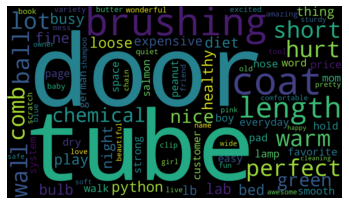

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(positive_topics_set))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
negative_topics_set = (get_difference(positive_topics,neutral_topics,negative_topics,"negative"))

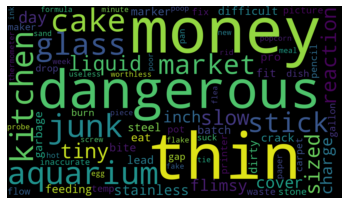

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(negative_topics_set))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
movies_df = df[df['category'] == 0]

In [ ]:
negative_movies_df = movies_df[movies_df['overall_category'] == 'negative']
neutral_movies_df = movies_df[movies_df['overall_category'] == 'neutral']
good_movies_df = movies_df[movies_df['overall_category'] == 'good']

In [ ]:
lda_model_negative_movies,dictionary_negative_movies,doc_term_matrix_negative_movies,tokenized_reviews_negative_movies = runLDA(negative_movies_df)

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_negative_movies,doc_term_matrix_negative_movies,dictionary_negative_movies)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.270587  0.066858       1        1  34.990464
6     -0.321143 -0.006103       2        1  20.294958
11    -0.245619 -0.236393       3        1  12.291824
14    -0.248475 -0.004152       4        1   9.072442
9     -0.071001  0.244951       5        1   7.137168
5     -0.120823  0.068693       6        1   5.210444
12     0.074391 -0.042029       7        1   2.360620
8      0.125447 -0.002888       8        1   1.612493
2      0.148821 -0.016897       9        1   1.275064
13     0.151407 -0.005628      10        1   1.262602
7      0.151719 -0.008663      11        1   1.086671
1      0.157511 -0.022580      12        1   1.064743
3      0.149568 -0.006062      13        1   1.055940
0      0.158072 -0.014740      14        1   0.721164
4      0.160710 -0.014366      15        1   0.563404, topic_info=          Term         Freq        Total Category  logprob  loglift
14       movie  3803.000000  3803.000000  Default  30.0000  30.0000
96     version   519.000000   519.000000  Default  29.0000  29.0000
26        film  2745.000000  2745.000000  Default  28.0000  28.0000
414        dvd   404.000000   404.000000  Default  27.0000  27.0000
2          bad  1179.000000  1179.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3914     setup     2.034855     9.595580  Topic15  -5.6685   3.6280
1437      ship     3.605592   108.792273  Topic15  -5.0965   1.7720
4247   climate     1.784608     6.065930  Topic15  -5.7998   3.9554
3629       gon     1.555787     5.921322  Topic15  -5.9370   3.8423
3157  exchange     1.535020     7.968734  Topic15  -5.9504   3.5319

[862 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2404      2  0.402041     1st
2404      3  0.160817     1st
2404     15  0.321633     1st
1241      1  0.694056     2nd
1241     15  0.231352     2nd
...     ...       ...     ...
774       2  0.118402   young
774       4  0.099707   young
774       5  0.043622   young
774       6  0.018695   young
4672      3  0.984418  zombie

[1513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 12, 15, 10, 6, 13, 9, 3, 14, 8, 2, 4, 1, 5])

In [ ]:
negative_topics_movies = get_topics(lda_model_negative_movies.print_topics())

In [ ]:
lda_model_neutral_movies,dictionary_neutral_movies,doc_term_matrix_neutral_movies,tokenized_reviews_neutral_movies = runLDA(neutral_movies_df)

In [ ]:
neutral_topics_movies = get_topics(lda_model_neutral_movies.print_topics())

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_neutral_movies,doc_term_matrix_neutral_movies,dictionary_neutral_movies)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.364337 -0.014297       1        1  55.284071
4      0.284092 -0.028214       2        1  13.903403
14     0.352959  0.036262       3        1  13.538155
5     -0.037774  0.025173       4        1   2.959943
8     -0.009253 -0.133516       5        1   2.761767
9     -0.060032 -0.170942       6        1   2.714091
1     -0.040532 -0.065873       7        1   2.579971
7     -0.010411  0.263965       8        1   2.274976
2     -0.104782  0.038078       9        1   1.278538
3     -0.127699  0.000634      10        1   0.999484
10    -0.117129  0.009942      11        1   0.498001
0     -0.125807  0.010734      12        1   0.373928
12    -0.126253  0.009668      13        1   0.355168
6     -0.124777  0.011057      14        1   0.331375
11    -0.116938  0.007328      15        1   0.147130, topic_info=             Term         Freq        Total Category  logprob  loglift
75           film  4525.000000  4525.000000  Default  30.0000  30.0000
265          star   848.000000   848.000000  Default  29.0000  29.0000
9           movie  4958.000000  4958.000000  Default  28.0000  28.0000
305           bad   905.000000   905.000000  Default  27.0000  27.0000
1270      episode   272.000000   272.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
16319      montag     0.014035     0.737816  Topic15  -9.7547   2.5595
8380        laser     0.014033     0.736239  Topic15  -9.7549   2.5614
16320      werner     0.014033     0.736350  Topic15  -9.7549   2.5613
7945   adjustment     0.014032     0.735288  Topic15  -9.7549   2.5627
10760        gear     0.014032     0.735799  Topic15  -9.7549   2.5620

[784 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2690     13  0.447867     20
4758     12  0.838127    4th
6581      1  0.525236     80
6581      5  0.447010     80
6581      9  0.011175     80
...     ...       ...    ...
204       1  0.726217   year
204       2  0.054140   year
204       3  0.214691   year
204       7  0.003734   year
138       1  0.996962  young

[1138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 15, 6, 9, 10, 2, 8, 3, 4, 11, 1, 13, 7, 12])

In [ ]:
lda_model_positive_movies,dictionary_positive_movies,doc_term_matrix_positive_movies,tokenized_reviews_positive_movies = runLDA(good_movies_df)

In [ ]:
positive_topics_movies = get_topics(lda_model_positive_movies.print_topics())

In [ ]:
LDAvis_prepared = gensimvis.prepare(lda_model_positive_movies,doc_term_matrix_positive_movies,dictionary_positive_movies)
LDAvis_prepared

In [ ]:
def save_topics(dataset,name):
    dataset = pd.DataFrame(dataset)
    dataset.to_csv(name+'.csv', index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

save_topics(negative_topics,'negative_topics')
save_topics(neutral_topics,'neutral_topics')
save_topics(positive_topics,'positive_topics')

save_topics(negative_topics_movies,'negative_topics_movies')
save_topics(neutral_topics_movies,'neutral_topics_movies')
save_topics(positive_topics_movies,'positive_topics_movies')

In [ ]:
positive_topics_movies = pd.read_csv('positive_topics_movies.csv', on_bad_lines='skip').values.tolist()
neutral_topics_movies = pd.read_csv('neutral_topics_movies.csv', on_bad_lines='skip').values.tolist()
negative_topics_movies = pd.read_csv('negative_topics_movies.csv', on_bad_lines='skip').values.tolist()

In [ ]:
positive_topics_set_movies = (get_difference(positive_topics_movies,neutral_topics_movies,negative_topics_movies,"positive"))

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(positive_topics_set_movies))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

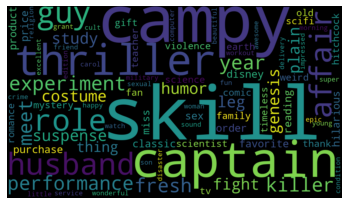

In [ ]:
negative_topics_set_movies = (get_difference(positive_topics_movies,neutral_topics_movies,negative_topics_movies,"negative"))

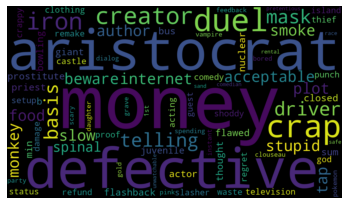

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(negative_topics_set_movies))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
grouped_counts = df.groupby('asin').count()
max_count = grouped_counts.max()
max_count_item = grouped_counts[grouped_counts == max_count].dropna().index[0]

In [ ]:
item_entries = df[df['asin'] == max_count_item]

In [ ]:
negative_asin_df = item_entries[item_entries['overall_category'] == 'negative']
neutral_asin_df = item_entries[item_entries['overall_category'] == 'neutral']
good_asin_df = item_entries[item_entries['overall_category'] == 'good']

In [ ]:
def run_mini_LDA(dataset):
    tokenized_reviews = tokenize(dataset)
    dictionary = corpora.Dictionary(tokenized_reviews)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,
                num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)
    # print lda topics with respect to each word of document
    return lda_model,dictionary,doc_term_matrix,tokenized_reviews

In [ ]:
def get_difference_asin(extracted_positive,extracted_neutral,extracted_negative,typeof):
    set1 = set([item for sublist in extracted_positive for item in sublist])
    set2 = set([item for sublist in extracted_neutral for item in sublist])
    set3 = set([item for sublist in extracted_negative for item in sublist])
    if(typeof=="positive"):
        return set1.difference(set2, set3)
    elif(typeof=="negative"):
        return set3.difference(set1,set2)

In [ ]:
lda_model_positive_asin,dictionary_positive_asin,doc_term_matrix_positive_asin,tokenized_reviews_positive_asin = run_mini_LDA(good_asin_df)

In [ ]:
positive_asin_topics = get_topics(lda_model_positive_asin.print_topics())

In [ ]:
lda_model_neutral_asin,dictionary_neutral_asin,doc_term_matrix_neutral_asin,tokenized_reviews_neutral_asin = run_mini_LDA(neutral_asin_df)

In [ ]:
neutral_asin_topics = get_topics(lda_model_neutral_asin.print_topics())

In [ ]:
lda_model_negative_asin,dictionary_negative_asin,doc_term_matrix_negative_asin,tokenized_reviews_negative_asin = run_mini_LDA(negative_asin_df)

In [ ]:
negative_asin_topics = get_topics(lda_model_negative_asin.print_topics())

In [ ]:
positive_topics_set_asin = (get_difference_asin(positive_asin_topics,neutral_asin_topics,negative_asin_topics,"positive"))

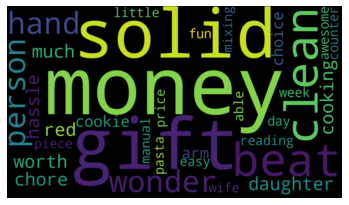

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(positive_topics_set_asin))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
negative_topics_set_asin = (get_difference_asin(positive_asin_topics,neutral_asin_topics,negative_asin_topics,"negative"))

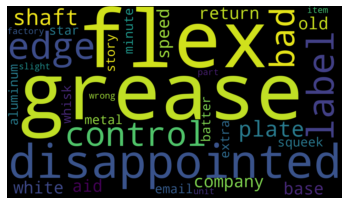

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(negative_topics_set_asin))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from summa import keywords

In [ ]:
def textrank(dataset):
    text = ' '.join(dataset)

    extracted_keywords = keywords.keywords(text).split('\n')

    return extracted_keywords

In [ ]:
extracted_positive_keywords = textrank(good_df['reviewText'].sample(n=1000, random_state=42))
extracted_neutral_keywords = textrank(neutral_df['reviewText'].sample(n=1000, random_state=42))
extracted_negative_keywords = textrank(negative_df['reviewText'].sample(n=1000, random_state=42))

In [ ]:
def get_positive_difference_keywords(extracted_positive_keywords,extracted_neutral_keywords,extracted_negative_keywords,alpha):
    set1 = set(extracted_positive_keywords[0:int(alpha*len(extracted_positive_keywords))])
    set2 = set(extracted_neutral_keywords[0:int(alpha*len(extracted_neutral_keywords))])
    set3 = set(extracted_negative_keywords[0:int(alpha*len(extracted_negative_keywords))])

    unique_words_in_set1 = set1.difference(set2, set3)
    return unique_words_in_set1

In [ ]:
positive_topics_set_textrank = (get_positive_difference_keywords(extracted_positive_keywords,extracted_neutral_keywords,extracted_negative_keywords,0.2))

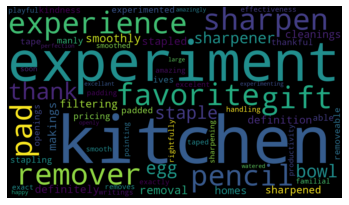

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(positive_topics_set_textrank))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def get_negative_difference_keywords(extracted_positive_keywords,extracted_neutral_keywords,extracted_negative_keywords,alpha):
    set1 = set(extracted_positive_keywords[0:int(alpha*len(extracted_positive_keywords))])
    set2 = set(extracted_neutral_keywords[0:int(alpha*len(extracted_neutral_keywords))])
    set3 = set(extracted_negative_keywords[0:int(alpha*len(extracted_negative_keywords))])

    unique_words_in_set3 = set3.difference(set1, set2)
    return unique_words_in_set3

In [ ]:
negative_topics_set_textrank = (get_negative_difference_keywords(extracted_positive_keywords,extracted_neutral_keywords,extracted_negative_keywords,0.2))

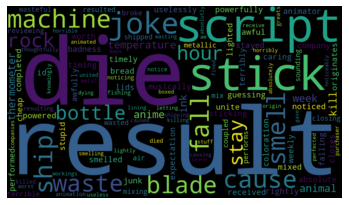

In [ ]:
wordcloud = WordCloud(width=1400, height=800).generate(' '.join(negative_topics_set_textrank))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()